In [ ]:
import numpy as np
import gzip
import matplotlib.pyplot as plt

In [ ]:
!curl https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz --output train.gz
!curl https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz --output train_label.gz
!curl https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz --output test.gz
!curl https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz --output test_label.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  25.4M      0 --:--:-- --:--:-- --:--:-- 25.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   200k      0 --:--:-- --:--:-- --:--:--  200k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  6492k      0 --:--:-- --:--:-- --:--:-- 6492k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  37850      0 --:--:-- --:--:-- --:--:-- 37850


In [ ]:
f = gzip.open('train.gz','r')
f.read(16)
buf = f.read()
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(-1, 784)
train = data

In [ ]:
f = gzip.open('train_label.gz','r')
f.read(8)
buf = f.read()
data = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)
data = data.reshape(-1)
labels = data

5


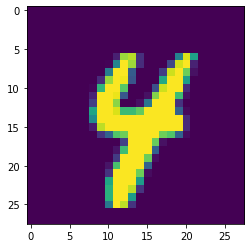

In [ ]:
image = np.asarray(train[-3]).squeeze()
print(labels[-3])
plt.imshow(image.reshape(28,28))
plt.show()

In [ ]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [ ]:
def relu(x):
  return np.maximum(x, 0)

In [ ]:
drelu(np.array([[1,2,3,4,-1,-2],[-1,-2,-3,4,5,6]]))

array([[1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1]])

In [ ]:
def drelu(x):
  return np.where(x>0,1,0)

In [ ]:
def softmax(x):
  exp = np.exp(x)
  sum = np.sum(exp,1).reshape(x.shape[0],1)
  return np.multiply(exp,1/sum)

In [ ]:
def dsoftmax(x):
  s = softmax(x).reshape(x.shape[0],-1)
  func = lambda y: np.diagflat(y) - np.dot(y.reshape(-1,1),y.reshape(-1,1).T) 
  return np.apply_along_axis(func,1,s)

In [ ]:
def loss(o,y):
  return np.mean(np.sum(np.square(o-y),axis=1))

In [ ]:
o = np.random.normal(size = (2,5))
y = np.array([[1,0,0,0,0],[0,0,1,0,0]])
loss(o,y)

2.3776913796388146

In [ ]:
def dloss(o,y):
  return 2*(o-y)

In [ ]:
dloss(o,y)

array([[ 5.35386862e-03,  3.44037972e-04,  2.61098731e-03, ...,
        -1.70166683e-01,  4.62514110e-03,  1.49312079e-01],
       [ 5.43801814e-04, -1.04740679e-01,  9.86169272e-03, ...,
         2.86547646e-03,  5.07593324e-02,  4.06076555e-03],
       [-1.72907090e+00,  4.51829960e-03,  1.88627886e-01, ...,
         3.63922544e-02,  2.16409317e-01,  4.69087122e-02],
       ...,
       [ 4.51252493e-04, -2.35238084e-01,  9.91163060e-02, ...,
         1.59897018e-03,  8.40673888e-02,  3.06471431e-03],
       [ 4.31109244e-04,  1.54306557e-02,  1.68120673e-02, ...,
         8.15453950e-04,  2.38426264e-02,  5.90663717e-04],
       [ 1.50099932e-03, -2.60812088e-01,  1.40853202e-01, ...,
         1.18651559e-02,  4.02084661e-02,  5.91615122e-03]])

In [ ]:
class MLP:
  def __init__(self, batch_size=32, lr = 0.001):
    self.linear1_matrix = np.random.normal(0,0.02,size = (200,784))
    self.linear1_bias = np.zeros(200)
    self.linear2_matrix = np.random.normal(0,0.02,size= (100,200))
    self.linear2_bias = np.zeros(100)
    self.linear3_matrix = np.random.normal(0,0.02,size=(10,100))
    self.linear3_bias = np.zeros(10)
    self.cache = {}
    self.lr = lr
    self.batch_size = batch_size
  def forward(self, x):
    self.cache['x'] = x
    self.cache['z1'] = np.matmul(x,self.linear1_matrix.T) + self.linear1_bias
    self.cache['a1'] = relu(self.cache['z1'])
    linear1_output = self.cache['a1']
    self.cache['z2'] = np.matmul(linear1_output,self.linear2_matrix.T) + self.linear2_bias
    self.cache['a2'] = relu(self.cache['z2'])
    linear2_output = self.cache['a2']
    self.cache['z3'] = np.matmul(linear2_output,self.linear3_matrix.T)+self.linear3_bias
    self.cache['a3'] = softmax(self.cache['z3'])
    output = self.cache['a3']
    return output
  def __call__(self, x):
    return self.forward(x)
  def backward(self,o,y):
    da3 = dloss(o,y).reshape(self.batch_size,1,-1)
    dz3 = np.matmul(da3,dsoftmax(self.cache['z3']))
    db3 = np.mean(dz3,axis =0).reshape(10,)
    dwl3 = np.matmul(np.transpose(dz3,axes = (0,2,1)),self.cache['a2'].reshape(self.batch_size,1,-1))
    da2 = np.matmul(dz3,self.linear3_matrix).reshape(self.batch_size,1,-1)
    dz2 = np.multiply(da2,drelu(self.cache['z2']).reshape(self.batch_size,1,-1))
    db2 = np.mean(dz2,axis =0).reshape(100,)
    dwl2 = np.matmul(np.transpose(dz2,axes = (0,2,1)),self.cache['a1'].reshape(self.batch_size,1,-1))
    da1 = np.matmul(dz2,self.linear2_matrix).reshape(self.batch_size,1,-1)
    dz1 = np.multiply(da1,drelu(self.cache['z1']).reshape(self.batch_size,1,-1))
    db1 = np.mean(dz1,axis =0).reshape(200,)
    dwl1 = np.matmul(np.transpose(dz1, axes = (0,2,1)),self.cache['x'].reshape(self.batch_size,1,-1))
    
    self.linear3_matrix -= self.lr * np.mean(dwl3,axis =0)
    self.linear2_matrix -= self.lr * np.mean(dwl2,axis =0)
    self.linear1_matrix -= self.lr * np.mean(dwl1,axis =0)

    self.linear3_bias -= self.lr * db3
    self.linear2_bias -= self.lr * db2
    self.linear1_bias -= self.lr * db1

In [ ]:
batch_size = 1000
mlp = MLP(batch_size=batch_size)

In [ ]:
num_epochs = (30*60000)//batch_size

In [ ]:
num_epochs

1800

In [ ]:
l=[]
for i in range(num_epochs):
  index = np.random.randint(0,60000-batch_size)
  x = train[index:index+batch_size]
  o = mlp(x)
  y = one_hot(labels[index:index+batch_size],10)
  print("Epoch",i+1,"Loss",loss(o,y))
  l.append(loss(o,y))
  mlp.backward(o,y)

Epoch 1 Loss 1.0106258000283226
Epoch 2 Loss 1.0083321315683416
Epoch 3 Loss 0.9830862733583493
Epoch 4 Loss 0.9834077835188421
Epoch 5 Loss 0.9730542995138726
Epoch 6 Loss 0.9802494634485073
Epoch 7 Loss 0.9817722473969578
Epoch 8 Loss 0.9782757720757872
Epoch 9 Loss 0.9661603118195594
Epoch 10 Loss 0.9753624277097013
Epoch 11 Loss 0.9647695689005044
Epoch 12 Loss 0.9606107515426189
Epoch 13 Loss 0.9620579470651953
Epoch 14 Loss 0.9411481858483378
Epoch 15 Loss 0.9430265390926311
Epoch 16 Loss 0.9422177752531632
Epoch 17 Loss 0.9304743072408862
Epoch 18 Loss 0.9425816918984323
Epoch 19 Loss 0.9239220965313155
Epoch 20 Loss 0.9068439081925191
Epoch 21 Loss 0.9313232582030299
Epoch 22 Loss 0.9092236042176757
Epoch 23 Loss 0.9141923634572503
Epoch 24 Loss 0.8968886541975621
Epoch 25 Loss 0.9136217896326128
Epoch 26 Loss 0.9105168974189621
Epoch 27 Loss 0.8890884752349532
Epoch 28 Loss 0.8940993468926292
Epoch 29 Loss 0.8781901414579099
Epoch 30 Loss 0.8908796752225703
Epoch 31 Loss 0.874

In [ ]:
mlp.linear1_bias

array([ 1.18638860e-05, -2.71003920e-06, -4.64872053e-07, -4.54623941e-06,
        2.07981892e-05,  1.87687322e-06, -1.55511075e-05,  2.05502607e-05,
        1.60891919e-05,  1.10751327e-05, -5.92257474e-06,  1.91095228e-05,
        1.40543046e-05,  1.00844706e-05, -5.07148231e-06, -4.46740816e-06,
        1.19784632e-05, -1.37495297e-06,  3.29898147e-06,  4.41865292e-06,
       -4.76429759e-06,  5.21968721e-06,  5.18840185e-06, -7.65342309e-06,
       -4.55529568e-06, -4.04927687e-06,  1.17334683e-05,  1.86474768e-05,
       -5.39567033e-06,  1.28944289e-06, -4.97243437e-06, -6.33784638e-06,
        1.52637604e-05,  4.45188849e-07,  7.01994591e-06,  8.96720431e-06,
       -5.41373115e-06,  1.56667142e-05,  2.58136480e-05,  1.79948042e-06,
        1.11496826e-05,  2.95703675e-05,  3.70509494e-07, -2.23685904e-06,
        4.32945519e-06,  1.89490316e-05,  2.76189798e-06, -1.44326812e-06,
        2.57789102e-06,  1.43074705e-06, -4.67015693e-06,  2.83471441e-05,
       -1.07176130e-05,  

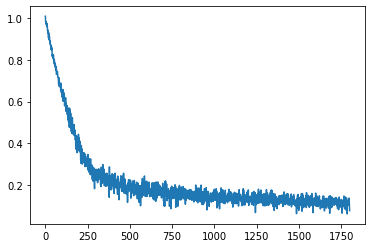

In [ ]:
plt.plot(l)

In [ ]:
ran = np.random.randint(0,60000-32)

In [ ]:
np.argmax(mlp(train[ran:ran+32]),axis = 1)

array([6, 3, 7, 6, 8, 4, 9, 6, 0, 9, 1, 1, 2, 7, 3, 2, 4, 0, 5, 9, 6, 6,
       7, 6, 8, 4, 9, 5, 0, 8, 1, 5])

In [ ]:
labels[ran:ran+32]

array([6, 3, 7, 6, 8, 4, 9, 5, 0, 9, 1, 1, 2, 7, 3, 2, 4, 0, 5, 9, 6, 6,
       7, 6, 8, 4, 9, 5, 0, 8, 1, 5], dtype=int32)

In [ ]:
index

24502

In [ ]:
f = gzip.open('test.gz','r')
f.read(16)
buf = f.read()
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(-1, 784)
test = data

In [ ]:
test.shape

(10000, 784)

In [ ]:
f = gzip.open('test_label.gz','r')
f.read(8)
buf = f.read()
data = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)
data = data.reshape(-1)
test_labels = data

In [ ]:
np.sum(np.equal(np.argmax(mlp(test),axis=1),test_labels))/10000

0.927

In [ ]:
np.where(np.equal(np.argmax(mlp(test),axis=1),test_labels)==False)

(array([   8,   33,   63,  124,  149,  217,  233,  241,  243,  245,  247,
         264,  282,  300,  318,  320,  321,  340,  341,  352,  359,  362,
         381,  389,  391,  412,  443,  444,  445,  448,  449,  468,  479,
         495,  502,  507,  511,  515,  531,  542,  543,  545,  551,  553,
         565,  569,  578,  582,  591,  606,  610,  613,  619,  627,  628,
         629,  659,  684,  689,  691,  707,  717,  720,  728,  740,  741,
         760,  839,  844,  857,  877,  881,  882,  890,  898,  924,  930,
         938,  939,  947,  950,  951,  956,  959,  962,  965,  992, 1003,
        1012, 1014, 1033, 1039, 1044, 1062, 1068, 1073, 1107, 1112, 1114,
        1119, 1125, 1181, 1182, 1191, 1192, 1194, 1198, 1200, 1204, 1206,
        1224, 1226, 1228, 1232, 1234, 1242, 1247, 1248, 1256, 1260, 1283,
        1289, 1290, 1298, 1299, 1310, 1315, 1319, 1326, 1337, 1345, 1364,
        1375, 1378, 1393, 1403, 1410, 1429, 1444, 1447, 1453, 1463, 1467,
        1494, 1500, 1514, 1522, 1525, 

6


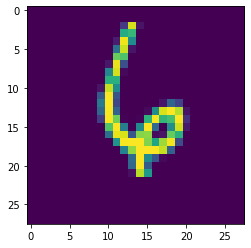

In [ ]:
image = np.asarray(test[6926]).squeeze()
print(test_labels[6926])
plt.imshow(image.reshape(28,28))
plt.show()

In [ ]:
6